In [1]:
# Normally, you can just use `pip install changepoynt` but for reproducibility, we install a certain
# commit from the package's GitHub repository.
!pip install git+https://github.com/Lucew/changepoynt.git@b4ea5ca606138578e2aa785dc921a5fe7af8c07d tqdm

  Cloning https://github.com/Lucew/changepoynt.git (to revision b4ea5ca606138578e2aa785dc921a5fe7af8c07d) to c:\users\lucas\appdata\local\temp\pip-req-build-d9jqzor8
  Resolved https://github.com/Lucew/changepoynt.git to commit b4ea5ca606138578e2aa785dc921a5fe7af8c07d
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached stumpy-1.13.0-py3-none-any.whl.metadata (28 kB)
Using cached stumpy-1.13.0-py3-none-any.whl (176 kB)
  Created wheel for changepoynt: filename=changepoynt-0.0.9-py3-none-any.whl size=59353 sha256=9612bb8a613ad75a8e215ff151a2e82bb2a139b083ff7f26ee1dd75d8f80f78f
  Stored in directory: c:\users\lucas\appdata\local\pip\cache\wheels\57\c5\6c\8837d2674d08cc7e458a4c44959a6bcd416495bd0b5a8f9

  Running command git clone --filter=blob:none --quiet https://github.com/Lucew/changepoynt.git 'C:\Users\lucas\AppData\Local\Temp\pip-req-build-d9jqzor8'
  Running command git rev-parse -q --verify 'sha^b4ea5ca606138578e2aa785dc921a5fe7af8c07d'
  Running command git fetch -q https://github.com/Lucew/changepoynt.git b4ea5ca606138578e2aa785dc921a5fe7af8c07d


In [2]:
import time

import numpy as np
from tqdm import tqdm

from changepoynt.algorithms.sst import SST

In [3]:
SIZE_FACTOR = 200

In [4]:
# simulate a signal that goes from exponential decline into a sine wave
# the signals is only for demonstration purposes and can be replaced by your signal
steady_before = np.ones(20*SIZE_FACTOR)
exp_signal = np.exp(-np.linspace(0, 5, 20*SIZE_FACTOR))
steady_after = np.exp(-5)*np.ones(15)
sine_after = 0.2*np.sin(np.linspace(0, 3*np.pi*10, 30*SIZE_FACTOR))
signal = np.concatenate((steady_before, exp_signal, steady_after, sine_after))
signal += 0.03*np.random.randn(signal.shape[0])  # add some minor noise

In [5]:
# create each of the detectors
# We enable the fast Hankel matrix product by: use_fast_hankel=True
# In order to save time, we only compute the change score at ever 50th sample (scoring_step=50)
window_size = 3*SIZE_FACTOR
scoring_step = 50
FFT_RSVD_SST = SST(window_size, method='rsvd', use_fast_hankel=True, scoring_step=scoring_step)
RSVD_SST = SST(window_size, method='rsvd', scoring_step=scoring_step)
FFT_IKA_SST = SST(window_size, method='ika', use_fast_hankel=True, scoring_step=scoring_step)
IKA_SST = SST(window_size, method='ika', scoring_step=scoring_step)
NAIVE_SVD = SST(window_size, method='naive updated', scoring_step=scoring_step)

In [6]:
# create an iterable with the detectors
detectors = {f'{NAIVE_SVD=}'.split('=')[0]: NAIVE_SVD, f'{RSVD_SST=}'.split('=')[0]: RSVD_SST, f'{FFT_RSVD_SST=}'.split('=')[0]: FFT_RSVD_SST, f'{IKA_SST=}'.split('=')[0]:IKA_SST, f'{FFT_IKA_SST=}'.split('=')[0]: FFT_IKA_SST}
namelength = max(len(key) for key in detectors.keys())

In [7]:
# go through each of the detectors (and keep the score of the naive method)
# On a Google Colab instance, this takes about 4 minutes
score = np.zeros_like(signal)
durations = {name: 0.0 for name in detectors.keys()}
errors = {name: -1 for name in detectors.keys()}
scores = dict()
for name, detector in tqdm(detectors.items(), desc="Running detectors"):

    # we have to trigger the JIT compiler first (otherwise we measure compile time)
    if not name.startswith('NAIVE'):
        _ = detector.transform(signal)

    # apply the detectors
    # as the decompositions are applied for several steps, we already get a balanced time measurement for several
    # decompositions that accounts for processing time variations due to CPU scheduling
    start = time.perf_counter()
    method_score = detector.transform(signal)
    durations[name] = time.perf_counter() - start
    scores[name] = method_score

    # create the ground truth from the naive method
    if name.startswith('NAIVE'):
        score = method_score

    # compute the error
    assert not np.all(score == 0), 'Naive method has to be the first.'
    errors[name] = np.mean(np.abs(score - method_score))

Running detectors: 100%|██████████| 5/5 [01:21<00:00, 16.34s/it]


In [8]:
# print the results to console
for name in detectors.keys():
    duration = durations[name]
    error = errors[name]
    print(f"{name: <{namelength}} took {duration:.2f} seconds for {signal.shape[0]//scoring_step} samples and N={window_size}.")
    print(f"Mean absolute error to naive SST: {error:.3E}")
    print()

NAIVE_SVD    took 66.66 seconds for 280 samples and N=600.
Mean absolute error to naive SST: 0.000E+00

RSVD_SST     took 2.36 seconds for 280 samples and N=600.
Mean absolute error to naive SST: 2.873E-08

FFT_RSVD_SST took 1.04 seconds for 280 samples and N=600.
Mean absolute error to naive SST: 2.249E-08

IKA_SST      took 2.33 seconds for 280 samples and N=600.
Mean absolute error to naive SST: 1.508E-06

FFT_IKA_SST  took 0.21 seconds for 280 samples and N=600.
Mean absolute error to naive SST: 1.254E-06



In [9]:
!pip install matplotlib

In [10]:
from changepoynt.visualization.score_plotting import plot_data_and_score

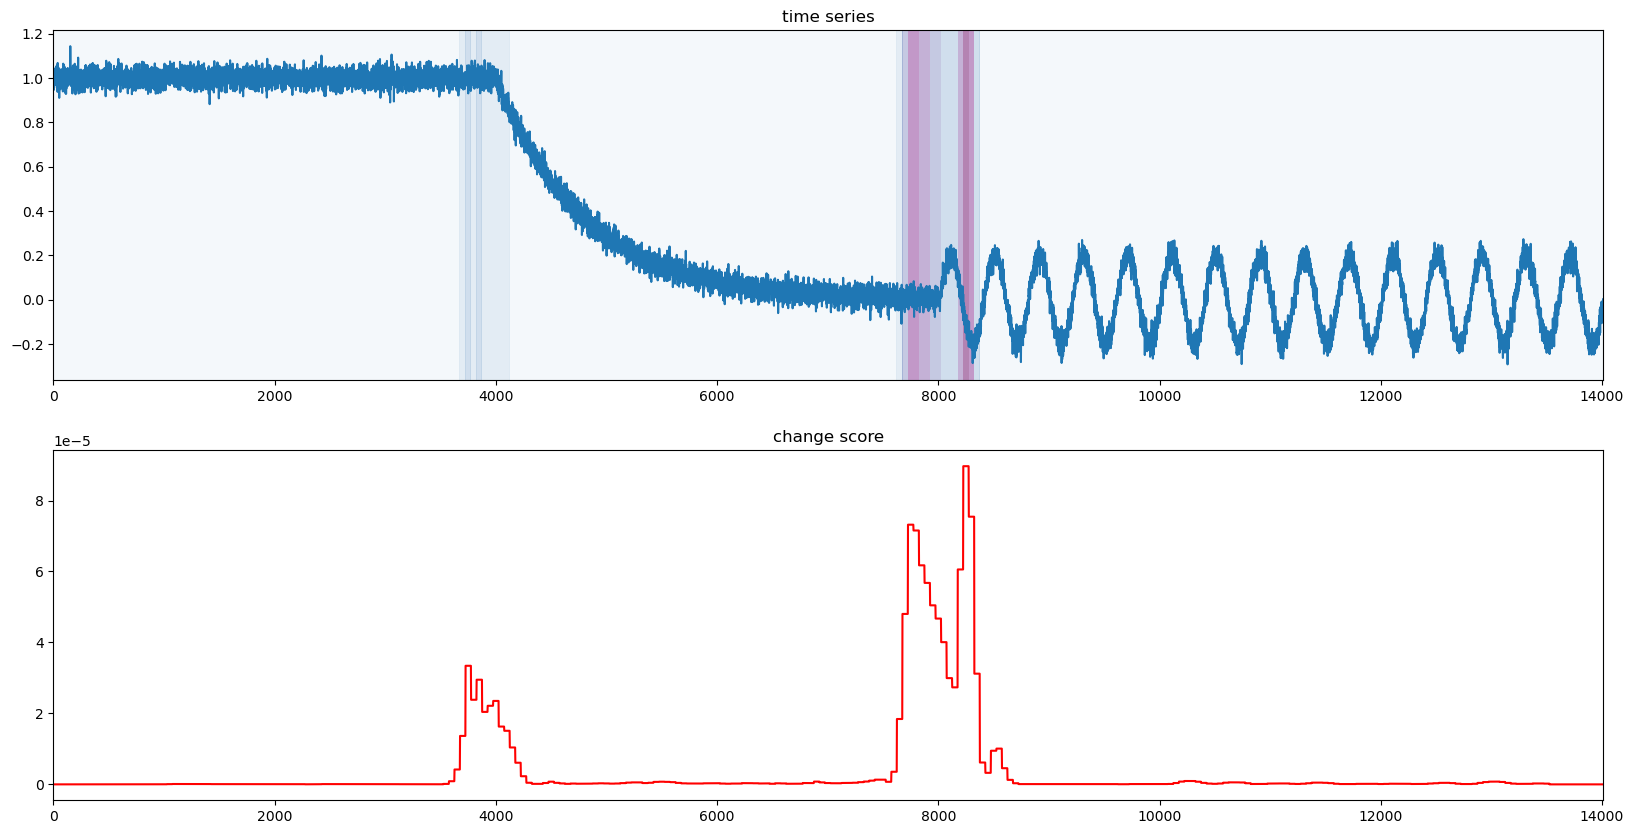

In [11]:
_ = plot_data_and_score(signal, scores['NAIVE_SVD'])

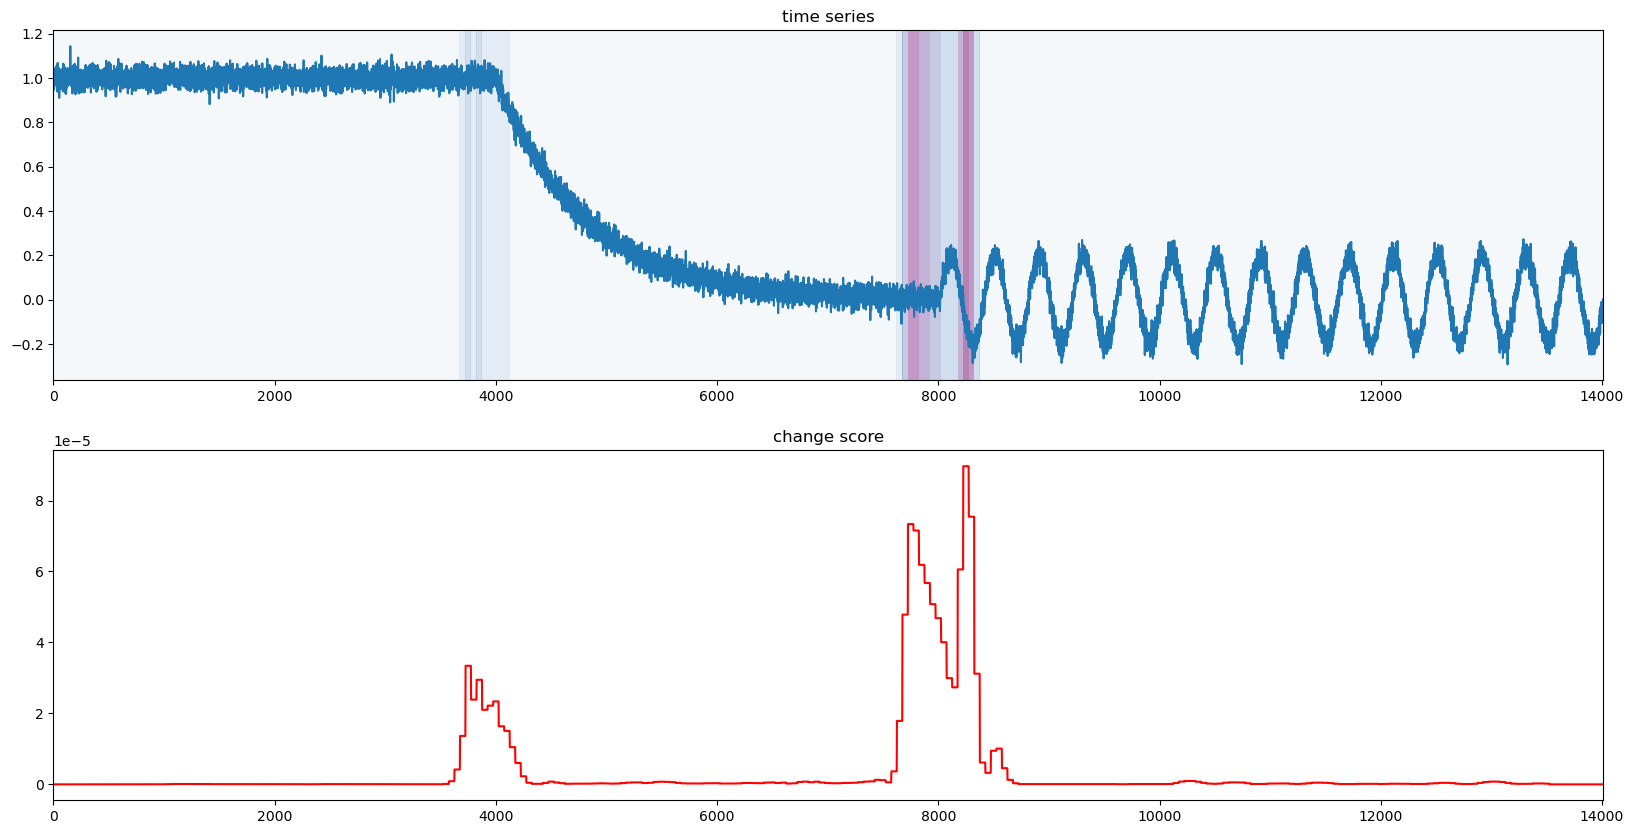

In [12]:
_ = plot_data_and_score(signal, scores['FFT_RSVD_SST'])

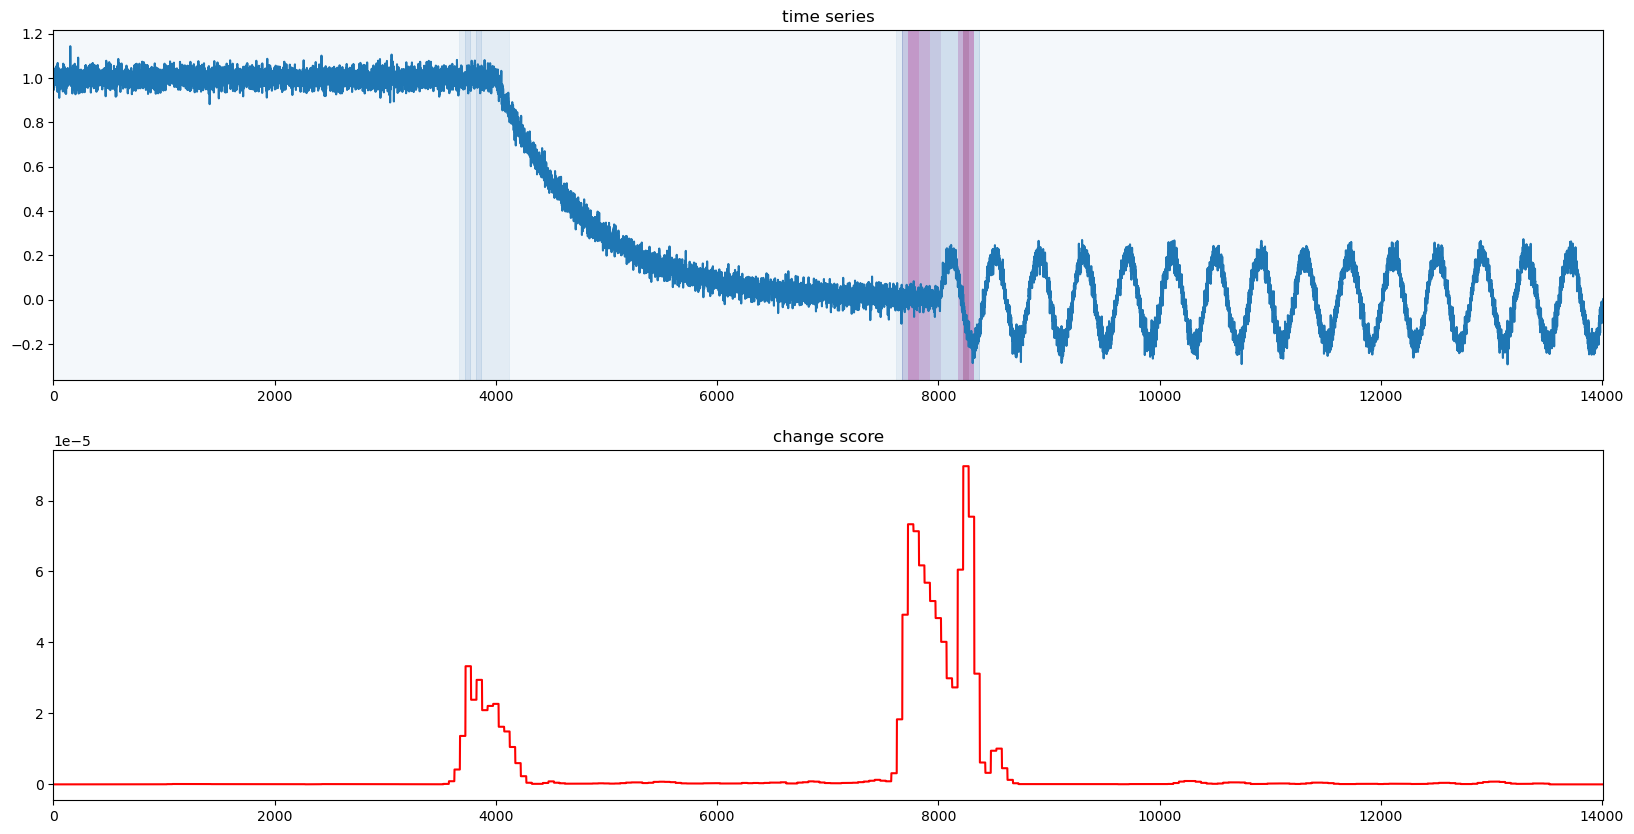

In [13]:
_ = plot_data_and_score(signal, scores['RSVD_SST'])

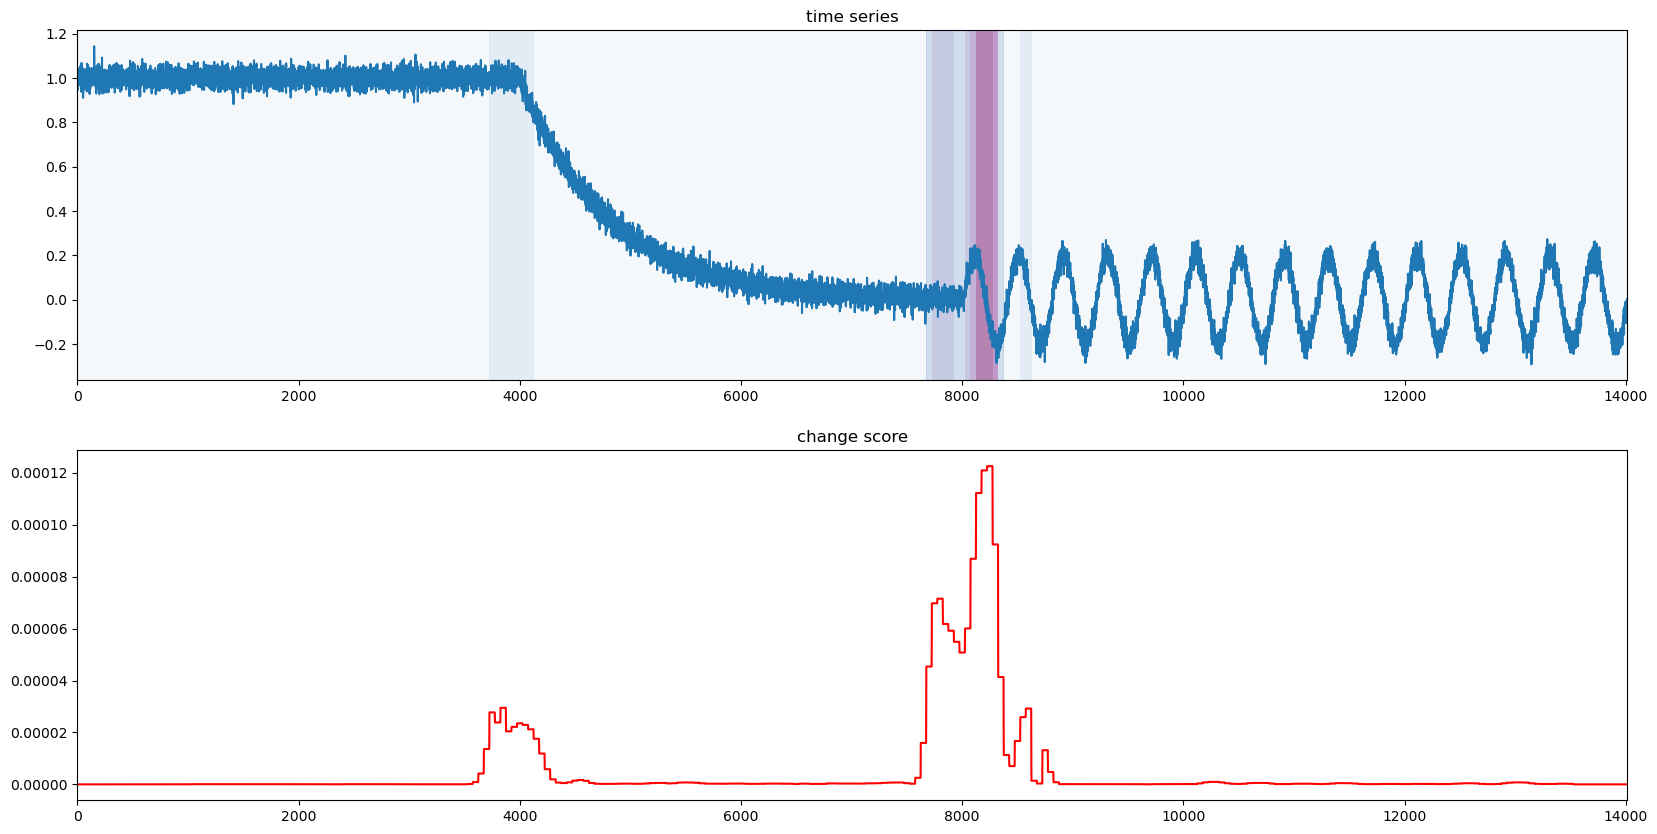

In [14]:
# see how the IKA-SST does not fully reproduce all peaks as mentioned in the paper (compared to NAIVE_SVD)
# this is independent of our speed-improvement and stems from the original algorithm
_ = plot_data_and_score(signal, scores['IKA_SST'])

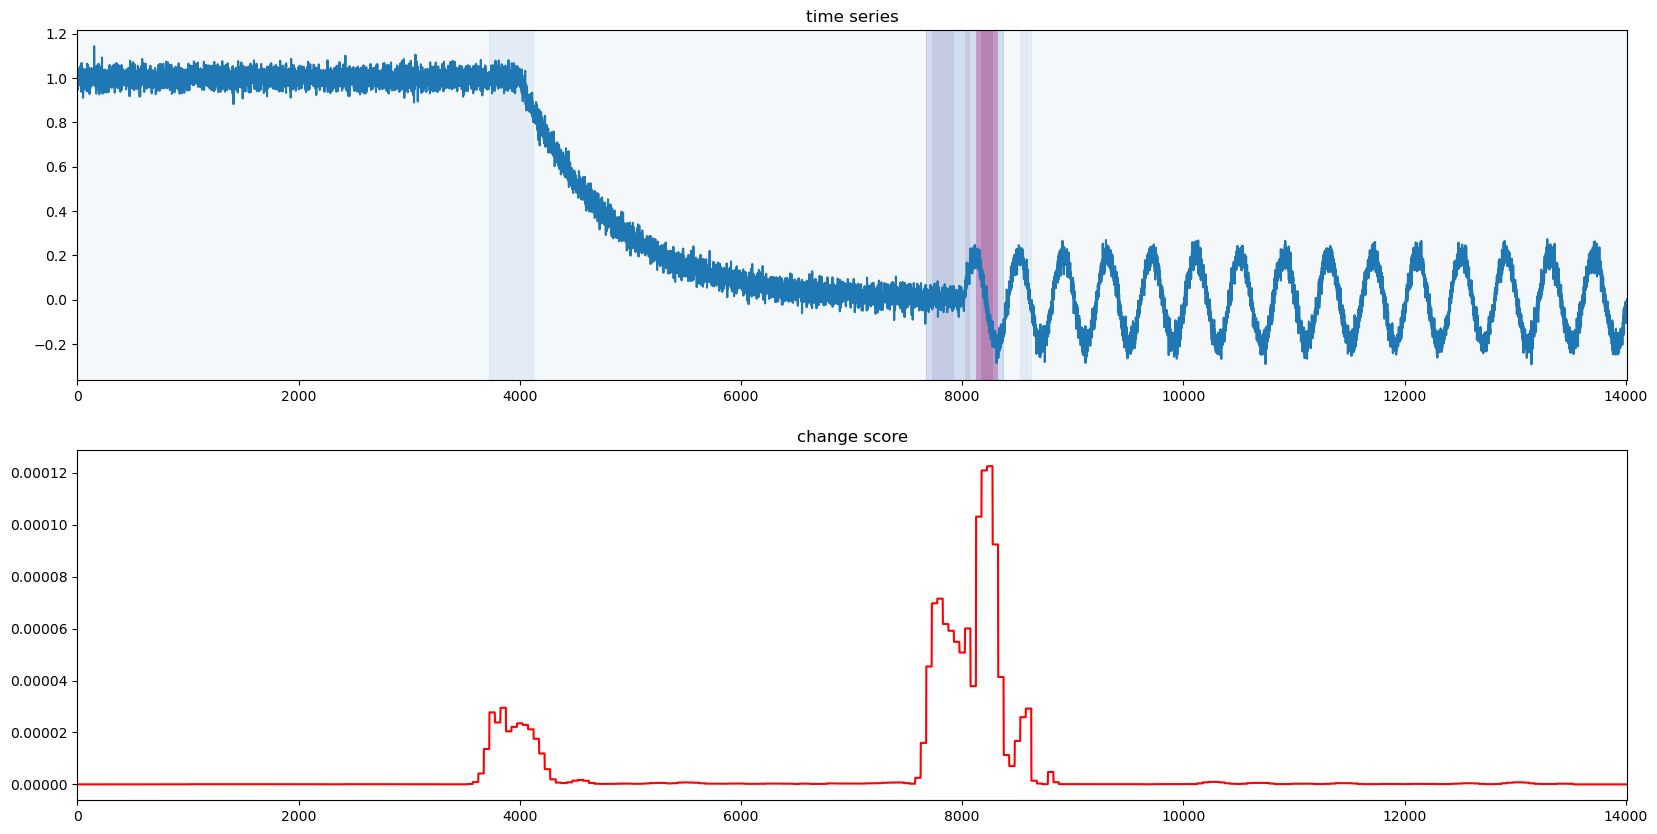

In [15]:
# see how the IKA-SST does not fully reproduce all peaks as mentioned in the paper (compared to NAIVE_SVD)
# this is independent of our speed-improvement and stems from the original algorithm
_ = plot_data_and_score(signal, scores['FFT_IKA_SST'])